In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from itertools import product
from itertools import combinations_with_replacement
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import time
import math
%matplotlib inline

In [3]:
from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances

In [4]:
from utils import *
%load_ext autoreload
%autoreload 2

In [154]:
gj = pd.read_csv('./gj_df.csv')
# gj = gj[['ifp_id', 'ctt', 'cond', 'training', 'team', 'user_id', 'value', 'fcast_date']]
# gj['fcast_year'] = pd.to_datetime(gj['fcast_date']).dt.year
# gj['fcast_week'] = pd.to_datetime(gj['fcast_date']).dt.week
# gj['ifp_week'] = gj['fcast_year'].map(str) + gj['fcast_week'].map(str) + gj['ifp_id']
# gj = gj.drop('fcast_date', axis=1)
# gj = gj.drop_duplicates()
# gj.to_csv('./gj_df.csv', index=False)

In [52]:
# adult = pd.read_csv('../labels.txt', delimiter='\t', header=0, names=['user_id','website','rating'])
# trec = pd.read_csv('../trec-rf10-crowd/trec-rf10-data.txt', delimiter='\t')
# gj = pd.read_csv('./filled_active_df.csv')

# best_users = trec.groupby('workerID').count().sort_values('docID', ascending=False)[:150].index
# trec = trec[trec['workerID'].isin(best_users)]

# r = pd.Series([2,3,2,3], index=[1,2,0,-2])
# trec['label_bin'] = trec['label'].map(r)
# adult.rating.unique()

array(['G', 'P', 'R', 'X'], dtype=object)

In [156]:
ifp_var = gj.groupby('ifp_week')['value'].var().sort_values()
ifps_less_var = (ifp_var<.1).index
ifps_less_var
testframe = testframe[testframe['ifp_week'].isin(ifps_less_var)]

In [56]:
# ratingcts = adult.groupby('user_id')['rating'].nunique()
# ratingcts = ratingcts[ratingcts==4]
# len(ratingcts)

389

In [159]:
# print(len(adult['user_id'].unique()))
# ratingcts = adult.groupby('user_id')['rating'].nunique()
# ratingcts = ratingcts[ratingcts==4]
# uids = ratingcts.index
# print(len(uids))
# adult = adult[adult['user_id'].isin(uids)]
# testframe = create_user_task_ids(adult, 'user_id', 'website', 'rating', prime=True)
# print(np.max(testframe['uid'].values))
testframe = create_user_task_ids(gj, 'user_id', 'ifp_week', 'value', False, True)
testframe.head()

,user_id,website,rating,bin,task_id,uid,bin_primes,bin_levels
3,A2LGX47NN7C5D3,http://000.cc,G,0,0,0,2,2
4,A2OVKTB7VNY8EW,http://000.cc,G,0,0,1,2,2
5,A31Z3E5SLATLML,http://000.cc,P,1,0,2,3,3
6,AAVCPZ8WTCFVK,http://000.cc,G,0,0,3,2,2
7,AHY98D5P05XIV,http://000.cc,G,0,0,4,2,2


In [160]:
print(testframe.shape)
print(len(testframe['uid'].unique()))
print(len(testframe['task_id'].unique()))

(65144, 8)
389
10381


In [173]:
testframe['value'] = (testframe['value'] - .5)*2
testframe['value'] = testframe['value']
# testframe['value'] = (testframe['value']*.5) + .5

In [195]:
testframe.head()

,ifp_id,ctt,cond,training,team,user_id,value,fcast_year,fcast_week,ifp_week,bin,task_id,uid,bin_levels
0,1244-0,1a,1,a,NaN,51,-0.6,2015,3,201531244-0,0.2,0,0,2
1,1244-0,1a,1,a,NaN,51,-0.6,2015,4,201541244-0,0.2,1,0,2
2,1244-0,1a,1,a,NaN,51,-0.6,2015,5,201551244-0,0.2,2,0,2
3,1244-0,1a,1,a,NaN,51,-0.6,2015,6,201561244-0,0.2,3,0,2
4,1244-0,1a,1,a,NaN,51,-0.6,2015,7,201571244-0,0.2,4,0,2


In [104]:
c = pd.cut(
    testframe['value'],
    [-np.inf, .2, .4, .6, .8, np.inf],
    labels=[2,3,5,7,11]
)
testframe['bin_levels'] = c

In [27]:
# testframe = testframe[testframe['uid']<1000]

In [118]:
def batcher(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def split(df):
    train_df, validate_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    return train_df, validate_df, test_df

class Model(nn.Module):
    def __init__(self, users, tasks, k=2):
        super(Model, self).__init__()
        self.user_lut = nn.Embedding(users, k)
        self.task_lut = nn.Embedding(tasks, k)

        self.user_bias = nn.Embedding(users, 1)
        self.task_bias = nn.Embedding(tasks, 1)
        self.global_bias = nn.Parameter(torch.FloatTensor(1))
        
    def forward(self, users, jokes):
        user_vectors = self.user_lut(users)
        task_vectors = self.task_lut(jokes)
        user_bias = self.user_bias(users)
        task_bias = self.task_bias(jokes)
        preds = torch.bmm(user_vectors.unsqueeze(1), task_vectors.unsqueeze(2)).squeeze() \
                         + user_bias.squeeze() + task_bias.squeeze() + self.global_bias.expand_as(user_bias.squeeze())
#         m = nn.Sigmoid()
        return preds
        
class Model2(nn.Module):
    def __init__(self, users, tasks, k=2):
        super(Model2, self).__init__()
        self.user_lut = nn.Embedding(users, k)
        self.task_lut = nn.Embedding(tasks, k)

        self.user_bias = nn.Embedding(users, 1)
        self.user_add_bias = nn.Embedding(users, 1)
        self.task_bias = nn.Embedding(tasks, 1)
        self.global_bias = nn.Parameter(torch.FloatTensor(1))
        
    def forward(self, users, jokes):
        user_vectors = self.user_lut(users)
        task_vectors = self.task_lut(jokes)
        user_bias = self.user_bias(users)
        task_bias = self.task_bias(jokes)
        user_add_bias = self.user_add_bias(users)

        preds = torch.bmm(user_vectors.unsqueeze(1), task_vectors.unsqueeze(2)).squeeze() \
                          + task_bias.squeeze() + self.global_bias.expand_as(user_bias.squeeze())
        m = nn.Tanh()
#         return m((user_bias.squeeze() * (preds - .5)) + .5)
#         return m(user_bias.squeeze() * preds )
        return m(user_bias.squeeze() * preds + user_add_bias.squeeze() )
            

def val(df, model):
    crit = nn.MSELoss(size_average=False)
    crit2 = nn.L1Loss(size_average=False)
    total_loss = 0.
    total_l1 = 0.
    total_num = 0
    for batch in batcher(df, 100):
        true_rating = Variable(torch.Tensor(batch.bin.values.astype(float)))
        total_num = total_num + true_rating.size(0)
        users = Variable(torch.LongTensor(batch.uid.values))
        tasks = Variable(torch.LongTensor(batch.task_id.values))
#         print(users, tasks)
        scores = model.forward(users, tasks)
        total_loss += crit(scores, true_rating).data[0]
        total_l1 += crit2(scores,true_rating).data[0]
    return math.sqrt(total_loss/total_num), total_l1/total_num


def train(train_iter, val_iter, test_iter, model):
    opt = optim.SGD(model.parameters(), lr=.9)
    crit = nn.MSELoss()
    crit2 = nn.L1Loss()

    print("val:", val(validate_df, model))
    for epochs in range(50):
        avg_loss = 0
        avg_l1 = 0
        total = 0
        for i,batch in enumerate(batcher(train_df, 100)):
            opt.zero_grad()
            rating = Variable(torch.Tensor(batch.bin.values.astype(float)))
#             print(rating)
            users = Variable(torch.LongTensor(batch.uid.values))
            tasks = Variable(torch.LongTensor(batch.task_id.values))
#             print(users, tasks)
            scores = model.forward(users, tasks) 
#             + torch.sum(model.user_lut.weight.data.pow(2)) + \
#             torch.sum(model.task_lut.weight.data.pow(2)) + torch.sum(model.user_bias.weight.data.pow(2)) + \
#             torch.sum(model.task_bias.weight.data.pow(2))
            loss = crit(scores, rating)
            #if i % 1000==0:
            #    print (loss.data[0])
            loss.backward()
            avg_loss += loss.data[0]
            avg_l1 += crit2(scores,rating).data[0]
            total += 1
            opt.step()
        print("train:", math.sqrt(avg_loss / float(total)), avg_l1/ float(total))
        print("val:", val(validate_df, model))
#         print(model.user_bias.weight.data)
    return model.user_lut.weight.data, model.user_bias.weight.data

In [119]:
train_df, validate_df, test_df = split(testframe)
validate_df = validate_df[validate_df['uid'].isin(train_df['uid'].values)][validate_df['task_id'].isin(train_df['task_id'].values)]

users = int(np.max(train_df.uid.unique()))
tasks = int(np.max(train_df.task_id.unique()))
print(users, tasks)
print(int(np.max(validate_df.uid.unique())))
print(int(np.max(validate_df.task_id.unique())))
model = Model2(users+1, tasks+1, k=4)
user_vec, user_bias = train(train_df, validate_df, test_df, model)

388 10380
388
10380
val: (2.6970005834564876, 2.1141692928248337)
train: 1.7928485236919074 1.377020536481267
val: (1.9083510788396418, 1.6013520283963503)
train: 1.3452194456083661 1.0592210289767332
val: (1.5168031530519093, 1.2393035342284107)
train: 1.2109570888360242 0.9533623226768221
val: (1.356291861763988, 1.093625904410174)
train: 1.116388487975432 0.8772270153550541
val: (1.2569957752245935, 1.0043823407318024)
train: 1.039852139598294 0.8151958359171972
val: (1.1843494197008357, 0.9390137011371005)
train: 0.9752090914714647 0.7625205384191039
val: (1.1270837567008452, 0.8875040367128286)
train: 0.9196058984022646 0.7169822507807057
val: (1.080084265919966, 0.8452345956678065)
train: 0.8713144134419144 0.6772512192921261
val: (1.0405264507858003, 0.8097755123723366)
train: 0.8291238094598108 0.6423555012706601
val: (1.0066627993069972, 0.7793431397771422)
train: 0.7921134868376278 0.6115545083952072
val: (0.9773280603823602, 0.7529184744088094)
train: 0.7595489232840791 0.58

In [121]:
user_vec, user_bias = model.user_lut.weight.data, model.user_bias.weight.data

In [122]:
user_features = np.zeros((user_vec.numpy().shape[0], user_vec.numpy().shape[1]+1))
user_features[:, :user_vec.numpy().shape[1]] = user_vec.numpy()
user_features[:, -1] = user_bias.numpy().reshape(-1)

In [123]:
user_features.shape

(389, 5)

In [93]:
# np.savetxt('./user_id_mapping.csv', testframe[['uid','user_id']].drop_duplicates().values)
# np.savetxt('./cluster_array_200.csv', kmeans.labels_)
# np.savetxt('./latent_vectors.csv', user_features)

In [124]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(user_features)
print(kmeans.labels_)

[20 18 78 20 18 98 99 43 98 39 90 18  3 43 39 59 18 39 20 18 20 20 18 98 61
  3 67 30 67 18 98 39 39 70 30 20 75 20 39 20 30 18 99 96 18 18 30 20 99 18
  0 77 84 18 57 19 78 18 18 39 39 20 81 81 43 41 39 18 14 39 39 30 77 18 20
 20 43 39  0  8  5 30 78 98 99  1 43 28 43 78 67 39 39  0 65 20 20 18 20  0
 90 20 53  0 90 39  3 59 78 49 78 73 39 39 39 30 86 47 20 18 18 30 39 78 78
 18 61 18 43 18 43 20 39 20 39 20 19 20 39 75  3 69 18 90 81 43 39 18 59 18
 63 42 83 18 90 43 91 48 18 39  0 18 44 63 59 39 31 70 60 18 75 18 78 53 28
 39 78 31 39 30 43 32 43 59 93  0  3 77 42 21 20 78  5 78 39 22 43 78 90 59
 20  5 96 20 20 20 90 30  3 30 48 75 18 94 63 46 67 96 38 90 18 43 42 75 30
 30  5  7 43 39 10 96 77 59 59 27 30 61  7  5 59 81 20 39  0 30 30 74 68 59
 32 71 30 11 30 73 61 10 70  7 83 42 31 39 67  5 84 20 30  3 84 21 24 58 90
 72 39  7 99 25 42 18 46 20 43 77 78 81 70 39 21 20 48 85  0 90 52 48 77 70
 73 13 55 96  3 39 70 78 22 83  3 84 67 81 78 78 86 29 75 30 75 19 78 77 70
 87 78 61 64

In [126]:
# completed, values, ind = compute_individual_dist(testframe, True, False)
completed, values, ind = compute_individual_dist(testframe, True, False)

In [128]:
start = time.time()
features = np.empty((ind.shape[0], ind.shape[1]**2*ind.shape[0]))
delta_matrices_all = np.empty((ind.shape[0], ind.shape[0], ind.shape[1], ind.shape[1]))
score_matrices_all = np.empty((ind.shape[0], ind.shape[0], ind.shape[1], ind.shape[1]))
for user_index in range(values.shape[0]):
#     print(ind[user_index])
    if user_index%100==0:
        print(user_index)
    #check for full joint distribution or add a prior later
    if np.sum(ind[user_index]==0) > 0:
        print(user_index)
        continue
    #compute delta matrices with all other users where applicable
    else:
        #create a mask so that other half of tasks can be used later to find score matrix
#         mask = np.random.randint(0,2,values.shape).astype(bool)
        mask = np.ones((values.shape)).astype(bool)
        delta_matrices, t_m_i_1, cluster_img = compute_deltas(user_index, completed, values, ind, mask, False, 2)
#         print(cluster_img)
        features[user_index,:] = cluster_img.flatten()
        delta_matrices_all[user_index,:,:,:] = delta_matrices
#         score_matrices, t_m_i_2 = compute_deltas(user_index, completed, values, ind, ~mask, True, 20)
#         score_matrices_all[user_index,:,:,:] = score_matrices
#         print(np.sum(t_m_i_1), np.sum(t_m_i_2))
#         if len(np.intersect1d(np.array(np.where(t_m_i_1==True)), np.array(np.where(t_m_i_2==True))))>0:
#             print(np.intersect1d(np.array(np.where(t_m_i_1==True)), np.array(np.where(t_m_i_2==True))))
#             print(regret(score_matrices, delta_matrices, \
#                      np.logical_and((t_m_i_1==True), (t_m_i_2==True))))
print(time.time()-start)

0
100
200
300
182.58380913734436


In [175]:
import pickle

In [176]:
# with open('./dm_all.pkl', 'wb') as f:
#     pickle.dump(delta_matrices_all, f)

In [183]:
# with open('./features.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [182]:
# with open('./dm_all.pkl', 'rb') as f:
#     x = pickle.load(f)
# print(np.array(x))
# print(np.array(x).shape)
type(x)

numpy.ndarray

In [129]:
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        print(i)
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [130]:
labels, centroids, X_hat = kmeans_missing(features, 100, max_iter=5)
print(labels)

0
1


/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


[79 84 37 37 28 16 54 21 23 15 15 15  7 15  4 37 37  6 37  7 29 46 83 34 19
 60 37 51  7 70 11 15 41 62 69 37  5 35 37 20 44 49 15 15 30 56 13 89 17  0
  7  7 27 48 42 37  7 15 53 15 15  2 37 37 12 37 38 15 37 74 96  9  7 22  7
 15 33 15 39 37  2  7  7 15  7  7 37 37 15  7 15 65 37  7  7 86 15 76 59 95
 71  7 81 15 37 72 37 15 37 15 73  7 50 37 52  8 37 62  7  0 43 24 78 90 87
  7 14 37 61 26 15  7 15 36 15 55 37 15 15 37 37  7 15 15 37  7 15 15  7 93
 15  7 15 94  7 15 15  7 15 15  7 15 15 37 64 15 37 15 37 68  2 15 99  2  7
 37 63 37 67 37  5 62  5 37  7 15 37 37 77 37  5  5 62 57 15  7 37  7  7 37
 15 37  0 91 15 37 37 18  5 69  7 37 80  7  7  7 37 15 37 37 15 37 82  5 47
 82  7 31 98 15 37 15 15 25 37 37 37  7 37 62 62  7 15 37  7 62  8 37 37 37
 37 37  5  7  7 45 97  7 15 37 15  7 37  7  7 37  7  5 62 62 10 37 37 37  7
 15 15 37  5 37  7 32 37 37 15 37 15  7 15 15 37 37 37 15  7 15 37 37 37 37
 58 37 40 37 37 15 15 15 37 15  7 66 15  7  5  5  7 37 62 62 75  7  7 37  7
 37 37 88 37

In [131]:
def calc_cluster_matrix_dist(labels, delta_matrices_all):
#     delta_matrices_new=np.zeros((len(np.unique(labels)), len(np.unique(labels)), delta_matrices_all[0][0].shape[0], \
#                                                               delta_matrices_all[0][0].shape[1]))
    delta_matrices_new=np.empty(delta_matrices_all.shape)
    for i in np.unique(labels):
        if i%100==0:
            print(i)
        missing = ~np.isfinite(delta_matrices_all)
        mu = np.nanmean(delta_matrices_all, 0, keepdims=0)
        filled = np.where(missing, mu, delta_matrices_all)
        cluster_i = np.average(filled[labels==i], axis=0)
        for j in np.unique(labels): 
            if np.sum(np.sum(np.isnan(cluster_i), (1,2)))>0:
                print(i,j)
                missing = ~np.isfinite(deltas_used)
                mu = np.nanmean(delta_matrices_all, 1, keepdims=1)
                X_hat = np.where(missing, mu, X)
            cluster_j = np.average(cluster_i[labels==j], axis=0)
#             delta_matrices_new[i,j] = cluster_j
            delta_matrices_new[np.ix_(labels==i,labels==j)] = cluster_j
    return delta_matrices_new

In [132]:
delta_matrices_all.shape

(389, 389, 4, 4)

In [217]:
delta_matrices_clust = calc_cluster_matrix_dist(kmeans.labels_, delta_matrices_all)
avg_dist = np.average([[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(delta_matrices_all.shape[0])] for j in range(delta_matrices_all.shape[0])])
max_dist = np.max([[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(delta_matrices_all.shape[0])] for j in range(delta_matrices_all.shape[0])])
print("K={} score: {}, {}".format(k_, avg_dist, max_dist))

0
100
200
300
K=4 score: 0.07798683683858106, 0.849352222276511


In [133]:
delta_matrices_clust_ref = calc_cluster_matrix_dist(labels, delta_matrices_all)
# avg_dist = np.average([[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(delta_matrices_all.shape[0])] for j in range(delta_matrices_all.shape[0])])
# max_dist = np.max([[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(delta_matrices_all.shape[0])] for j in range(delta_matrices_all.shape[0])])
# print("K={} score: {}, {}".format(k_, avg_dist, max_dist))

0


In [147]:
delta_matrices_clust = calc_cluster_matrix_dist(kmeans.labels_, delta_matrices_all)
# print(np.average([[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(1000)] for j in range(1000)]))

0
100


In [167]:
for k_ in range(2,11):
    model = Model2(users, tasks, k=k_)
    user_vec, user_bias = train(train_df, validate_df, test_df, model)
    user_features = np.zeros((user_vec.numpy().shape[0], user_vec.numpy().shape[1]+1))
    user_features[:, :user_vec.numpy().shape[1]] = user_vec.numpy()
    user_features[:, -1] = user_bias.numpy().reshape(-1)
    kmeans = KMeans(n_clusters=400, random_state=0).fit(user_features)
    delta_matrices_clust = calc_cluster_matrix_dist(kmeans.labels_, delta_matrices_all)
    pd = [[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(delta_matrices_all.shape[0])] for j in range(delta_matrices_all.shape[0])]
    avg_dist = np.average(pd)
    max_dist = np.max(pd)
    print("K={} score: {}, {}".format(k_, avg_dist, max_dist))

val: (0.6987190232629525, 0.5700266969052522)
train: 0.5587561793864447 0.44557927274582065
val: (0.47552665723685394, 0.38366568446049243)
train: 0.4349172522847618 0.35672646145414594
val: (0.40763345544557533, 0.34064426782586715)
train: 0.38803979868488286 0.32854561751858297
val: (0.3759200289668357, 0.3222991213493633)
train: 0.36499612961060546 0.3153550618635834
val: (0.3589411806939865, 0.31189319669916693)
train: 0.35114515586270795 0.3053264139048679
val: (0.346517363927786, 0.30045238237119964)
train: 0.33806265307542965 0.290064672280638
val: (0.33129667145267505, 0.28016804956587654)
train: 0.3205448214671272 0.26721464876680173
val: (0.31337363726686623, 0.25731300726060896)
train: 0.30762496787012644 0.25132154614369356
val: (0.30553574115434756, 0.24832530998355237)
train: 0.3024787430806144 0.2456613460289817
val: (0.3023188558894671, 0.24497890023656374)
train: 0.2996086697996544 0.2432284078176894
val: (0.2992738193297631, 0.2426309807977303)
train: 0.29707627365382

val: (0.2949551887793111, 0.2382697740913897)
train: 0.2934419785503004 0.23685293514803285
val: (0.29390538064193994, 0.23739576067955714)
train: 0.29219773222908857 0.23580339587910168
val: (0.2924065425003174, 0.2362784227007358)
train: 0.29014246383165987 0.23430113106462466
val: (0.2904469815321397, 0.23476577823720296)
train: 0.28885452025043257 0.23315416725344953
val: (0.28946574334346686, 0.23379729138130712)
0
100
200
300
K=4 score: 0.07758545924960727, 0.8114071965300811
val: (0.7667574496358466, 0.6344576256642014)
train: 0.6223367388440045 0.49368091484489524
val: (0.5316755941101969, 0.42035053703736036)
train: 0.48546743422749616 0.38744647371578134
val: (0.45549789231281673, 0.36807584677179256)
train: 0.42839976244810685 0.35048034098107
val: (0.41221191481658903, 0.3410076483772996)
train: 0.3965320378478991 0.3310868235105353
val: (0.3873613323021625, 0.32580447683483543)
train: 0.3746452447761022 0.3159647030899158
val: (0.36646552214422906, 0.3066878015804941)
trai

val: (0.3185912365730198, 0.2568602775912711)
train: 0.31522144842513217 0.2547484975144194
val: (0.3167973333588779, 0.2556423593375029)
train: 0.31390536915517375 0.2537588278728625
val: (0.3160913090822942, 0.2549506447822245)
train: 0.31305066658829206 0.25300238552975785
val: (0.3149386225274137, 0.25411759649090127)
train: 0.3113081338011834 0.2518546485262163
val: (0.31196095812316826, 0.2523439658212948)
train: 0.3091595491342864 0.25040802216963165
val: (0.3109048624455329, 0.2514460184977888)
train: 0.3077523706394613 0.2493967609691217
val: (0.3090168882121285, 0.25019495904777006)
train: 0.306505124727177 0.2483934728356667
val: (0.3084312331946184, 0.2495195232514999)
train: 0.3059113098179588 0.24773954765406542
val: (0.30787890733138834, 0.24889236377987303)
train: 0.30529208666342855 0.2470908850984687
val: (0.3072481368545186, 0.2482389756009523)
0
100
200
300
K=7 score: 0.07734997638804927, 0.8260714229701096
val: (0.801995367724474, 0.6676676668710564)
train: 0.65038

train: 0.32331292506124537 0.2657472934009049
val: (0.32419123879794853, 0.2666890371006366)
train: 0.32097695243266433 0.2638924211319975
val: (0.32247483442260083, 0.26526458928285607)
train: 0.3190485979243796 0.262288048359859
val: (0.32073307908675036, 0.26383211450031435)
train: 0.317536683507393 0.2609325712053921
val: (0.31962881035822616, 0.26274861977716807)
train: 0.31631455885052556 0.25972686902271636
val: (0.3184741732181556, 0.26162881915663183)
train: 0.31496229631605255 0.2586323471119559
val: (0.31704241950448064, 0.2605538703392519)
train: 0.31355984369117157 0.25757265214842656
val: (0.31598799535281513, 0.2596443682457096)
train: 0.31294266448266206 0.2568672169919224
val: (0.31546644696157855, 0.25898499118774054)
train: 0.312263735152001 0.256175969627538
val: (0.3146020807604743, 0.25823526023155463)
train: 0.3108375199680039 0.2552138650785716
val: (0.312880265021581, 0.25714074125606656)
train: 0.3097551884039399 0.25431586414072027
val: (0.31234560503802367, 

In [217]:
np.sum(np.isnan(user_features))

0

In [172]:
for k_ in range(2,11):
    model = Model(users, tasks, k=k_)
    user_vec, user_bias = train(train_df, validate_df, test_df, model)
    user_features = np.zeros((user_vec.numpy().shape[0], user_vec.numpy().shape[1]+1))
    user_features[:, :user_vec.numpy().shape[1]] = user_vec.numpy()
    user_features[:, -1] = user_bias.numpy().reshape(-1)
    kmeans = KMeans(n_clusters=400, random_state=0).fit(user_features)
    delta_matrices_clust = calc_cluster_matrix_dist(kmeans.labels_, delta_matrices_all)
    pd = [[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(delta_matrices_all.shape[0])] for j in range(delta_matrices_all.shape[0])]
    avg_dist = np.average(pd)
    max_dist = np.max(pd)
    print("K={} score: {}, {}".format(k_, avg_dist, max_dist))

val: (0.4639765714452453, 0.3785863400954292)
train: 0.3976220150586197 0.30140647537784343
val: (0.3912996700760621, 0.2963129679616412)
train: 0.3863972378421258 0.29263850707824146
val: (0.38062887830351594, 0.28842775033556545)
train: 0.3753557607375847 0.2843337796525777
val: (0.3697756650199848, 0.28035144153860714)
train: 0.3643174652003573 0.27597536014955326
val: (0.3590453509619917, 0.2723341927365815)
train: 0.3535626744462106 0.26779745229453233
val: (0.34869543649570905, 0.264581396840703)
train: 0.34330981102246094 0.2599818534112178
val: (0.3389087563180287, 0.2572293087311685)
train: 0.3337010423494056 0.25264784855715905
val: (0.3297905049900379, 0.2503603597860713)
train: 0.3248055021277796 0.24586431130356076
val: (0.3213801578220503, 0.24403993506454463)
train: 0.3166362003742733 0.2396479972276676
val: (0.31367251720931305, 0.23824667026333188)
train: 0.3091720462633454 0.23399006022432742
val: (0.3066401457352175, 0.23295336697792132)
train: 0.3023767937079633 0.2

KeyboardInterrupt: 

In [145]:
kmeans = SpectralClustering(n_clusters=200).fit(user_features)
# delta_matrices_clust = calc_cluster_matrix_dist(kmeans.labels_, delta_matrices_all)
# avg_dist = np.average([[pairwise_distances(delta_matrices_clust[i,j], delta_matrices_all[i,j]) for i in range(1000)] for j in range(1000)])
# print("K={} score: {}".format(k_, avg_dist))

In [146]:
kmeans.labels_

array([ 44, 168, 196,  93, 168, 166, 182, 113, 166,  25, 110,  63,   5,
       173, 125, 155,  81, 101,  28,  75,  89,  22,  98, 166, 193,  92,
         6, 119,   6,  70, 166, 156,  91, 174, 195,  69, 152,  45,  12,
        40, 195,  54, 194, 161,  90, 109, 169,   8,   9,  52, 103, 194,
         4, 168,   9, 170, 138, 100, 154,  31,  33,  55,   9,   1, 162,
         9,  29, 127, 172,  56,  50,  78, 185, 111,  18, 142,  30,  94,
        96,   9,   1, 143, 158, 166,   1,   4,  67, 175,  74, 102,   6,
        88,  58, 106, 161,  38, 126,  37,  46,  83, 164,   3, 181,  43,
       124,  77, 188, 192, 140,   9, 134, 193, 163,  14,  19, 179, 184,
       178, 116, 129,  79, 169,  47,  72,  15, 121, 193, 149,   0,  59,
        10,  60,  42,  11,  61,  26, 170,  39,  86, 152,  82, 192, 160,
         2, 190,  73,  35, 118, 177, 168, 191, 196, 173, 168, 167, 148,
       184, 191, 168,  97, 177, 137, 199, 186,  71,  80, 192, 174, 199,
       168, 152, 150, 117, 181, 183, 114, 152, 192,  16, 152, 13

In [222]:
sc.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [191]:
for i, param in enumerate(model.parameters()):
    np.savetxt('./test_{}'.format(i), param.data.numpy())
    print(i, param.data.numpy())

0 [-1.26082933]
1 [[-0.39793867  0.67628181  1.1686765  -0.7427668 ]
 [ 0.71048403 -0.78146476 -0.29446998 -0.21856749]
 [-1.30848157  0.59841329  0.31170163 -0.07004142]
 ..., 
 [-0.12140504 -0.25585377 -0.11752333  0.05447096]
 [ 0.2422477  -0.65883136 -0.6978479  -0.34982434]
 [-0.92756301 -1.06573153 -1.64558303 -0.55912602]]
2 [[ 0.3497223   0.11227955  0.42520446  0.30817065]
 [ 0.0609895  -0.10946952  0.16272642 -0.17210275]
 [-0.10992495 -0.036178    0.12413357 -0.42531428]
 ..., 
 [ 0.59692997  0.90453321  0.41128317  0.60188913]
 [ 0.5215283   0.32531875 -1.06333375 -0.93270755]
 [ 1.04257977  1.01841938  1.00617087 -0.80307019]]
3 [[ 0.94279188]
 [-0.91361088]
 [-1.17880964]
 ..., 
 [ 0.34308255]
 [ 0.81045347]
 [-0.61459929]]
4 [[-1.00959754]
 [-0.78255588]
 [-0.95955992]
 ..., 
 [ 0.12014688]
 [ 0.3620224 ]
 [ 0.47548157]]


In [190]:
with open('./test_pd.pkl', 'wb') as f:
    pickle.dump(pd, f)

In [219]:
print(delta_matrices_clust[0,0]) 
print(delta_matrices_all[0,0])

[[-0.03850098 -0.00070619 -0.00251558  0.00492479 -0.00810864]
 [-0.01367145  0.00419112  0.0025168   0.00543623  0.00199566]
 [-0.00511168  0.00354283  0.00876775  0.00368143  0.0028533 ]
 [-0.00517798  0.00571605  0.00293797  0.0069204   0.00460551]
 [-0.01270993  0.00311497  0.00271329  0.00537838  0.01720596]]
[[ 0.18454485 -0.05865035 -0.00266644 -0.11463426 -0.01521456]
 [-0.05865035  0.15605807 -0.00128753 -0.08659634 -0.010848  ]
 [-0.00266644 -0.00128753  0.02146133 -0.00528638  0.00181503]
 [-0.11463426 -0.08659634 -0.00528638  0.21334369 -0.02351102]
 [-0.01521456 -0.010848    0.00181503 -0.02351102  0.05835177]]


In [220]:
pairwise_distances(delta_matrices_clust[0,0], delta_matrices_all[0,0])

array([[ 0.25971494,  0.18266406,  0.04541026,  0.23844652,  0.07674275],
       [ 0.24078773,  0.18367389,  0.02500055,  0.24974557,  0.06513833],
       [ 0.23300941,  0.18591987,  0.01649054,  0.25489434,  0.06462982],
       [ 0.23523939,  0.18564499,  0.02356406,  0.25292491,  0.06473865],
       [ 0.24126224,  0.18645239,  0.02867682,  0.2518097 ,  0.05224576]])

In [148]:
np.average(np.abs(delta_matrices_clust - delta_matrices_all))

0.021972585625869595

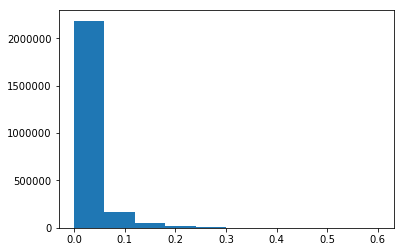

In [150]:
plt.hist(np.abs(delta_matrices_clust - delta_matrices_all).flatten())
plt.show()

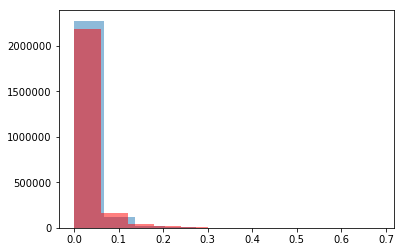

In [153]:
plt.hist(np.abs(delta_matrices_clust_ref - delta_matrices_all).flatten(), alpha=.5)
plt.hist(np.abs(delta_matrices_clust - delta_matrices_all).flatten(), alpha=.5, color='r')
plt.show()

In [149]:
np.max(np.abs(delta_matrices_clust - delta_matrices_all))

0.60110056142430368

In [138]:
np.max(np.abs(delta_matrices_clust_ref - delta_matrices_all))

0.68299466548434962

In [141]:
delta_matrices_all

array([[[[ 0.19249209, -0.07486806, -0.05794249, -0.06922621],
         [-0.07486806,  0.09484536, -0.00765522, -0.00936041],
         [-0.05794249, -0.00765522,  0.07604623, -0.00699209],
         [-0.06922621, -0.00936041, -0.00699209,  0.08870529]],

        [[-0.07679419,  0.00593934,  0.02490498,  0.00268276],
         [-0.0766963 ,  0.01976156,  0.01926943,  0.01926943],
         [-0.03249219,  0.02030838,  0.01992561,  0.04214783],
         [-0.069369  ,  0.01994383,  0.04171038,  0.01948816]],

        [[-0.23537528, -0.0121463 ,  0.00132952, -0.04707506],
         [ 0.05794702,  0.0209412 ,  0.03557094,  0.02825607],
         [-0.01048565,  0.02554686,  0.03692555,  0.0312362 ],
         [-0.02041943,  0.02247642,  0.03602248,  0.02924945]],

        ..., 
        [[-0.07948675, -0.07948675, -0.07948675, -0.22147351],
         [ 0.04104305,  0.04104305,  0.04104305,  0.01958609],
         [ 0.04581126,  0.04581126,  0.04581126,  0.02912252],
         [ 0.04263245,  0.04263245,

In [144]:
np.set_printoptions(precision=5, suppress=True)
delta_matrices_clust

array([[[[-0.2655 , -0.03537,  0.00279, -0.0243 ],
         [-0.03537,  0.04028,  0.04537,  0.03118],
         [ 0.00279,  0.04537,  0.04608,  0.04373],
         [-0.0243 ,  0.03118,  0.04373,  0.05236]],

        [[-0.34638, -0.00418,  0.02688,  0.00879],
         [-0.04779,  0.04207,  0.04922,  0.03923],
         [-0.00454,  0.04639,  0.04593,  0.04762],
         [-0.03618,  0.03563,  0.04795,  0.04937]],

        [[-0.25658, -0.07774,  0.00408, -0.03749],
         [-0.016  ,  0.02873,  0.04735,  0.03275],
         [ 0.01512,  0.04348,  0.04953,  0.04693],
         [-0.00691,  0.03005,  0.04836,  0.04833]],

        ..., 
        [[-0.06677, -0.0718 , -0.0718 , -0.20506],
         [ 0.03007,  0.03143,  0.03317,  0.00005],
         [ 0.04749,  0.05059,  0.04749,  0.03352],
         [ 0.04007,  0.04143,  0.04007,  0.02004]],

        [[-0.11694, -0.11993, -0.06721, -0.10574],
         [ 0.02238,  0.01866,  0.03239,  0.02142],
         [ 0.04338,  0.04353,  0.04678,  0.04276],
         

In [229]:
print(model.user_add_bias.weight.data)


 0.5337
 0.1677
 0.3572
   ⋮    
 0.3238
 0.2746
 0.3138
[torch.FloatTensor of size 2052x1]

